# Detecting Lung Cancer

## 📖 Background


My task is to build a simple machine learning model that can help classify lung cell images into three groups:

- Benign cells
- Adenocarcinoma cells
- Squamous cells carcinoma




## 🩻 The Data


The dataset is <a href="https://www.kaggle.com/datasets/rm1000/lung-cancer-histopathological-images/data?select=adenocarcinoma"> Chest X-Ray Images </a> and contains three main folders:

- Adenocarcinoma: 5000 images
- Benign: 5000 images 
- Squamous cell carcinoma: 5000 images 

In [ ]:
#Get the data from Kaggle
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rm1000/lung-cancer-histopathological-images")

print("Path to dataset files:", path) #use this path to extract the data later

100%|██████████| 1.55G/1.55G [01:22<00:00, 20.2MB/s]

Extracting files...


Path to dataset files: C:\Users\Asus user\.cache\kagglehub\datasets\rm1000\lung-cancer-histopathological-images\versions\1


In [ ]:
path = "" #fill this in with the path from above for faster results next time

In [4]:
#Will load ResNet18 weights here to help load the images

import torch
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights 
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

weights = ResNet18_Weights.DEFAULT # get the default weights of the model
transform_resnet = weights.transforms() # need this to load the images for ResNet

transform_cnn = transforms.Compose([
    transforms.Resize((224, 224)), #The original size (768, 768) is too large, need to downsize to reduce the compilation time during training
    #transforms.RandomRotation(30),
    #transforms.RandomHorizontalFlip(),
    #transforms.Grayscale(num_output_channels=1), # force grayscale
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # center around 0
])

In [5]:
#Loading the image data and getting the labels:
#Using the path from earlier

from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import Subset

full_dataset_resnet = datasets.ImageFolder(root=path, transform=transform_resnet)
full_dataset_cnn = datasets.ImageFolder(root=path, transform=transform_cnn)

targets_resnet = np.array(full_dataset_resnet.targets)
targets_cnn = np.array(full_dataset_cnn.targets)

#15000 images are too many to run on cpu so I will only be using a subset of the data
subset_dataset_resnet_idx, _ = train_test_split(np.arange(len(targets_resnet)), test_size=0.94, stratify=targets_resnet, random_state=42)
subset_dataset_cnn_idx, _ = train_test_split(np.arange(len(targets_cnn)), test_size=0.94, stratify=targets_cnn, random_state=42)

#Need to split the dataset into train, test and validation sets, I do this to make sure the classes are balanced
train_dataset_resnet_idx, temp_dataset_resnet_idx = train_test_split(subset_dataset_resnet_idx, test_size=0.333, stratify=targets_resnet[subset_dataset_resnet_idx], random_state=42)
train_dataset_cnn_idx, temp_dataset_cnn_idx = train_test_split(subset_dataset_resnet_idx, test_size=0.333, stratify=targets_cnn[subset_dataset_cnn_idx], random_state=42)

val_dataset_resnet_idx, test_dataset_resnet_idx = train_test_split(temp_dataset_resnet_idx, test_size=0.666, stratify=targets_resnet[temp_dataset_resnet_idx], random_state=42)
val_dataset_cnn_idx, test_dataset_cnn_idx = train_test_split(temp_dataset_cnn_idx, test_size=0.666, stratify=targets_cnn[temp_dataset_cnn_idx], random_state=42)

train_dataset_resnet = Subset(full_dataset_resnet, train_dataset_resnet_idx)
val_dataset_resnet = Subset(full_dataset_resnet, val_dataset_resnet_idx)
test_dataset_resnet = Subset(full_dataset_resnet, test_dataset_resnet_idx)

train_dataset_cnn = Subset(full_dataset_resnet, train_dataset_cnn_idx)
val_dataset_cnn = Subset(full_dataset_resnet, val_dataset_cnn_idx)
test_dataset_cnn = Subset(full_dataset_resnet, test_dataset_cnn_idx)

batch_size = 64

train_loader_resnet = DataLoader(train_dataset_resnet, batch_size=batch_size, shuffle=True)
val_loader_resnet   = DataLoader(val_dataset_resnet, batch_size=batch_size, shuffle=False)
test_loader_resnet  = DataLoader(test_dataset_resnet, batch_size=batch_size, shuffle=False)

train_loader_cnn = DataLoader(train_dataset_cnn, batch_size=batch_size, shuffle=True)
val_loader_cnn   = DataLoader(val_dataset_cnn, batch_size=batch_size, shuffle=False)
test_loader_cnn  = DataLoader(test_dataset_cnn, batch_size=batch_size, shuffle=False)

In [6]:
#to see each class
print(full_dataset_resnet.classes)           # List of class names in alphabetical order
print(full_dataset_resnet.class_to_idx)      # Dictionary: {'class_name': index}

['adenocarcinoma', 'benign', 'squamous_cell_carcinoma']
{'adenocarcinoma': 0, 'benign': 1, 'squamous_cell_carcinoma': 2}


In [72]:
#CNN architecture
class CNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3, out_channels=32,
                            kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
            torch.nn.Conv2d(in_channels=32, out_channels=64,
                            kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
            torch.nn.Conv2d(in_channels=64, out_channels=128,
                            kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
            torch.nn.Conv2d(in_channels=128, out_channels=64,
                            kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
            torch.nn.Flatten(),
            torch.nn.Linear(12544, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 3)
        )
        

    def forward(self, x):
        return self.model(x)

In [52]:
model_cnn = CNN().to(device)
print(model_cnn)

CNN(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=50176, out_features=64, bias=True)
    (11): ReLU()
    (12): Linear(in_features=64, out_features=3, bias=True)
  )
)


In [73]:
#Training for CNN:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_cnn = CNN().to(device)

criterion_cnn = torch.nn.CrossEntropyLoss()
optimizer_cnn = torch.optim.Adam(model_cnn.parameters(), lr=0.001, weight_decay=0.01)

epochs = 10
for epoch in range(epochs):
    model_cnn.train()
    running_loss = 0.0
    for inputs, labels in train_loader_cnn:
        inputs, labels = inputs.to(device), labels.long().to(device)
        optimizer_cnn.zero_grad()
        outputs = model_cnn(inputs)
        loss = criterion_cnn(outputs, labels)
        loss.backward()
        optimizer_cnn.step()
        running_loss += loss.item() * inputs.size(0)

    model_cnn.eval()
    val_loss = 0.0
    correct = 0
    for inputs, labels in val_loader_cnn:
        inputs, labels = inputs.to(device), labels.long().to(device)
        outputs = model_cnn(inputs)
        loss = criterion_cnn(outputs, labels)
        val_loss += loss.item() * inputs.size(0)

        # Calculate the accuracy for the classification
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item() 

    val_acc = correct / len(val_loader_cnn.dataset)
    epoch_val_loss = val_loss / len(val_loader_cnn.dataset)
    epoch_loss = running_loss / len(train_loader_cnn.dataset)
    print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f} - Validation Accuracy: {val_acc:.4f} - Validation Loss: {epoch_val_loss:.4f}")

Epoch 1/10 - Loss: 1.1077 - Validation Accuracy: 0.6400 - Validation Loss: 0.9988
Epoch 2/10 - Loss: 0.7013 - Validation Accuracy: 0.7600 - Validation Loss: 0.5836
Epoch 3/10 - Loss: 0.4777 - Validation Accuracy: 0.6800 - Validation Loss: 0.6492
Epoch 4/10 - Loss: 0.4663 - Validation Accuracy: 0.7700 - Validation Loss: 0.5159
Epoch 5/10 - Loss: 0.4333 - Validation Accuracy: 0.8000 - Validation Loss: 0.4924
Epoch 6/10 - Loss: 0.4087 - Validation Accuracy: 0.8100 - Validation Loss: 0.4697
Epoch 7/10 - Loss: 0.3585 - Validation Accuracy: 0.8200 - Validation Loss: 0.4633
Epoch 8/10 - Loss: 0.3413 - Validation Accuracy: 0.8500 - Validation Loss: 0.3875
Epoch 9/10 - Loss: 0.2725 - Validation Accuracy: 0.8200 - Validation Loss: 0.4701
Epoch 10/10 - Loss: 0.2745 - Validation Accuracy: 0.8600 - Validation Loss: 0.4185


In [74]:
#Evaluation for the CNN model:
from sklearn.metrics import accuracy_score, precision_score, recall_score

model_cnn.eval()
all_preds_cnn = []
all_labels_cnn = []

with torch.no_grad():
    for inputs, labels in test_loader_cnn:
        inputs = inputs.to(device)
        outputs = model_cnn(inputs)
        #preds = (torch.sigmoid(outputs) > 0.5).float() #for 1 class
        preds = torch.argmax(outputs, dim=1) #for 2 classes
        all_preds_cnn.extend(preds.cpu().numpy().ravel())
        all_labels_cnn.extend(labels.numpy().ravel())

acc_cnn = accuracy_score(all_labels_cnn, all_preds_cnn)
prec_cnn = precision_score(all_labels_cnn, all_preds_cnn, average = None)
rec_cnn = recall_score(all_labels_cnn, all_preds_cnn, average = None)

print(f"Accuracy: {acc_cnn:.4f}")
print("Precision by classes:")
print(prec_cnn)
print("Recall by classes")
print(rec_cnn)

Accuracy: 0.8850
Precision by classes:
[0.86440678 0.90540541 0.88059701]
Recall by classes
[0.77272727 1.         0.88059701]


In [33]:
#ResNet
model_resnet = resnet18(weights=weights)
print(model_resnet.fc) #1000 classes

#It needs to classify into two classes: "healthy" and "tb", so:
num_classes = 3 
model_resnet.fc = nn.Linear(model_resnet.fc.in_features, num_classes)
print(model_resnet.fc) #2 classes

Linear(in_features=512, out_features=1000, bias=True)
Linear(in_features=512, out_features=3, bias=True)


In [ ]:
#Training step for ResNet
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_resnet = model_resnet.to(device)

criterion_resnet = nn.CrossEntropyLoss()  # for two classes
optimizer_resnet = optim.Adam(model_resnet.parameters(), lr=1e-4)

epochs = 5
for epoch in range(epochs):
    model_resnet.train()
    running_loss = 0.0
    for inputs, labels in train_loader_resnet:
        inputs, labels = inputs.to(device), labels.long().to(device)
        optimizer_resnet.zero_grad()
        outputs = model_resnet(inputs)
        loss = criterion_resnet(outputs, labels)
        loss.backward()
        optimizer_resnet.step()
        running_loss += loss.item() * inputs.size(0)
        
    model_resnet.eval()
    val_loss = 0.0
    correct = 0
    for inputs, labels in val_loader_resnet:
        inputs, labels = inputs.to(device), labels.long().to(device)
        outputs = model_resnet(inputs)
        loss = criterion_cnn(outputs, labels)
        val_loss += loss.item() * inputs.size(0)

        # Calculate the accuracy for the classification
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()

    val_acc = correct / len(val_loader_resnet.dataset)
    epoch_val_loss = val_loss / len(val_loader_resnet.dataset)
    epoch_loss = running_loss / len(train_loader_resnet.dataset)
    print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f} - Validation Accuracy: {val_acc:.4f} - Validation Loss: {epoch_val_loss:.4f}")

Epoch 1/5 - Loss: 0.0659 - Validation Accuracy: 97.0000 - Validation Loss: 6.4628
Epoch 2/5 - Loss: 0.0375 - Validation Accuracy: 99.0000 - Validation Loss: 3.3089
Epoch 3/5 - Loss: 0.0198 - Validation Accuracy: 97.0000 - Validation Loss: 5.2727
Epoch 4/5 - Loss: 0.0082 - Validation Accuracy: 96.0000 - Validation Loss: 8.4988
Epoch 5/5 - Loss: 0.0093 - Validation Accuracy: 99.0000 - Validation Loss: 6.0331


In [42]:
#Evaluation on the test data
from sklearn.metrics import accuracy_score, precision_score, recall_score

model_resnet.eval()
all_preds_resnet = []
all_labels_resnet = []

with torch.no_grad():
    for inputs, labels in test_loader_resnet:
        inputs = inputs.to(device)
        outputs = model_resnet(inputs)
        preds = torch.argmax(outputs, dim=1) #for 2 classes
        all_preds_resnet.extend(preds.cpu().numpy().ravel())
        all_labels_resnet.extend(labels.numpy().ravel())

acc_resnet = accuracy_score(all_labels_resnet, all_preds_resnet)
prec_resnet = precision_score(all_labels_resnet, all_preds_resnet, average = None)
rec_resnet = recall_score(all_labels_resnet, all_preds_resnet, average = None)

print(f"Accuracy: {acc_resnet:.4f}")
print("Precision by classes:")
print(prec_resnet)
print("Recall by classes")
print(rec_resnet)

Accuracy: 0.9950
Precision by classes:
[0.98507463 1.         1.        ]
Recall by classes
[1.         1.         0.98507463]


<Figure size 40000x20000 with 0 Axes>

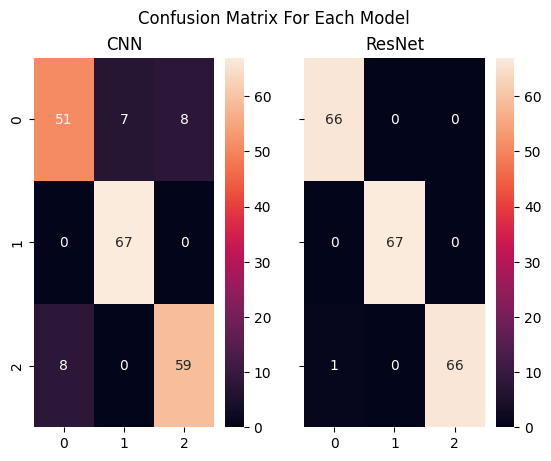

In [75]:
#Evaluation metrics for each model with confusion matrix
from sklearn.metrics import confusion_matrix

confusion_matrix_cnn = confusion_matrix(all_labels_cnn, all_preds_cnn)
confusion_matrix_resnet = confusion_matrix(all_labels_resnet, all_preds_resnet)

sensitivity_cnn = confusion_matrix_cnn[1][1] #How many TB cases your model correctly finds.
specificity_cnn = confusion_matrix_cnn[0][0] #How many healthy cases your model correctly identifies.
ppv_cnn = confusion_matrix_cnn[1][1] / 50 #When your model says “TB”, how often it’s right.
npv_cnn = confusion_matrix_cnn[0][0] / 50 #When your model says “Healthy”, how often it’s right.


sensitivity_resnet = confusion_matrix_resnet[1][1] #How many TB cases your model correctly finds.
specificity_resnet = confusion_matrix_resnet[0][0] #How many healthy cases your model correctly identifies.
ppv_resnet = confusion_matrix_resnet[1][1] / 50 #When your model says “TB”, how often it’s right.
npv_resnet = confusion_matrix_resnet[1][1] / 50 #When your model says “Healthy”, how often it’s right.

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(400,200))
figure, axis = plt.subplots(1, 2, sharey= True, sharex=True)
sns.heatmap(confusion_matrix_cnn, ax=axis[0], vmin=0, annot=True)
plt.suptitle("Confusion Matrix For Each Model")
axis[0].set_title("CNN")
sns.heatmap(confusion_matrix_resnet, ax=axis[1], vmin=0, annot=True)
axis[1].set_title("ResNet")
plt.show()

From the above visual, we can observe that the CNN model tends to label benign images correctly, but it missrepresents the other two categories.

For the ResNet models, the predictions are balanced with 99.5% accuracy, a satisfying result. Using the full dataset would probably yeald a similar result.